<a href="https://colab.research.google.com/github/g-nightingale/ml-algorithms/blob/master/RNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##GRU from scratch <br>

Author: Geoff Nightingale <br>
Date: 21/05/2020 <br>

In [101]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

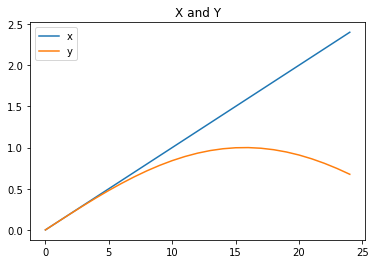

In [109]:
# Create training data
X = np.array([x/10.0 for x in range(25)])
Y = np.sin(X)
# Y = X**2

# Plot training data
plt.figure()
plt.title('X and Y')
plt.plot(X, label='x')
plt.plot(Y, label='y')
plt.legend()
plt.show()

In [3]:
def initialize_parameters(n_h, n_x, n_y):
    """ Initialize network parameters """
    np.random.seed(1)

    Wr = np.random.randn(n_h, n_h)*0.01
    Ur = np.random.randn(n_h, n_x)*0.01
    br = np.zeros((n_h, 1))

    Wz = np.random.randn(n_h, n_h)*0.01
    Uz = np.random.randn(n_h, n_x)*0.01
    bz = np.zeros((n_h, 1))

    Wh = np.random.randn(n_h, n_h)*0.01
    Uh = np.random.randn(n_h, n_x)*0.01
    bh = np.zeros((n_h, 1))

    Wy = np.random.randn(n_y, n_h)*0.01
    by = np.zeros((n_y, 1))

    parameters = {"Wr": Wr, "Ur": Ur, "br": br, "Wz": Wz, "Uz": Uz, "bz": bz, \
                  "Wh": Wh, "Uh": Uh, "bh": bh, "Wy": Wy, "by": by}
    
    return parameters


In [59]:
def sigmoid(z, deriv=False):
  """ Sigmoid activation function """
  sig = 1/(1 + np.exp(-z))
  
  if deriv is False:
    return sig
  else:
    return sig * (1- sig)

def tanh(z, deriv=False):
  """ Tanh activation function """
  tanh = (np.exp(z) - np.exp(-z))/(np.exp(-z) + np.exp(z))
  
  if deriv is False:
    return tanh
  else:
    return (1- tanh**2)


In [5]:
def rnn_step_forward(parameters, h_prev, x):
    """ RNN single step forward """
    Wr, Ur, br, Wz, Uz, bz, Wh, Uh, bh, Wy, by  = parameters['Wr'], parameters['Ur'], parameters['br'], \
                                                  parameters['Wz'], parameters['Uz'], parameters['bz'], \
                                                  parameters['Wh'], parameters['Uh'], parameters['bh'], \
                                                  parameters['Wy'], parameters['by']

    r_t = sigmoid(np.dot(Ur, x) + np.dot(Wr, h_prev) + br)
    z_t = sigmoid(np.dot(Uz, x) + np.dot(Wz, h_prev) + bz)
    h_hat = tanh(np.dot(Uh, x) + np.dot(Wh, (r_t * h_prev)) + bh)
    h_next = z_t * h_hat + (1 - z_t) * h_prev
    p_t = np.dot(Wy, h_next) + by
    
    return r_t, z_t, h_hat, h_next, p_t

In [7]:
def rnn_forward(X, Y, h0, parameters):
    """ RNN forward propagation """
    # Initialize empty dictionaries
    x, r, z, h_hat, h, y_hat = {}, {}, {}, {}, {}, {}
    
    h[-1] = np.copy(h0)
    
    # Initialize loss to 0
    loss = 0
    
    # Forward propagation of RNN
    for t in range(len(X)):
        if X.ndim == 1:
            x = X[t]
        else:
            x = X[t].reshape((1, X.shape[1]))

        r[t], z[t], h_hat[t], h[t], y_hat[t] = rnn_step_forward(parameters, h[t-1], x)

        # Update loss
        #loss -= np.log(y_hat[t][Y[t],0])
        loss += np.sum((y_hat[t] - Y[t])**2)

    cache = (x, r, z, h_hat, h, y_hat)
    
    return loss, cache


In [8]:
# Testing forward prop
t = 0
n_h = 3
n_x = 1
n_y = 1
m = X.shape[0]

parameters = initialize_parameters(n_h, n_x, n_y)

h_prev = np.zeros((n_h, 1))

# Run one step forward of the RNN
if X.ndim == 1:
    x = X[t]
else:
    x = X[t].reshape((1, X.shape[1]))

r_t, z_t, h_hat, h_next, p_t = rnn_step_forward(parameters, h_prev, x)

print('X[t]', x)
print('X', X.shape)
print('r_t', r_t.shape)
print('z_t', z_t.shape)
print('h_hat', h_hat.shape)
print('h_next', h_next.shape)
print('p_t', p_t.shape)


X[t] 0.0
X (25,)
r_t (3, 1)
z_t (3, 1)
h_hat (3, 1)
h_next (3, 1)
p_t (1, 1)


In [9]:
def print_shape(label, array):
  print(label, array.shape)

In [84]:
 def rnn_step_backward(dy, gradients, parameters, x, r, z, h_hat, h, h_prev):
    """ RNN single step backward """
    if dy.ndim == 1:
        dy_sum = np.sum(dy)
    else:
        dy_sum = np.sum(dy, axis=1, keepdims=True)

    # Grads through y_hat
    gradients['dWy'] += np.dot(dy, h.T)
    gradients['dby'] += dy_sum
    dh = np.dot(parameters['Wy'].T, dy_sum) + gradients['dh_next']

    # Hidden layer derivatives
    dz = np.multiply(dh, -h_prev)
    dh_prev = (1 - z)
    dh_prev_1 = np.multiply(dh, dh_prev)
    dh_hat = np.multiply(dh, z)

    # Dim check
    # dh (2, 100)
    # h_prev (2, 100)
    # h_prev_1 (2, 100
    # z (2, 100)

    # Grads through h_hat
    dh_hat_1 = np.multiply(dh_hat, tanh(h_hat, deriv=True))
    dh_h_prev = np.multiply(np.dot(parameters['Wh'].T, dh_hat_1), r)
    dWh = np.dot(dh_hat_1, np.multiply(r, h_prev).T)
    dUh = np.dot(dh_hat_1, x.T)
    dbh = np.sum(dh_hat_1, axis=1, keepdims=True)

    gradients['dWh'] += dWh
    gradients['dUh'] += dUh
    gradients['dbh'] += dbh

    # Intermedidate grad for reset gate that comes through h_hat  
    dr = np.multiply(np.dot(parameters['Wh'].T, dh_hat_1), h_prev)

    # Dim check
    # dh_hat (2, 100)
    # dh_hat_1 (2, 100)   
    # h_prev (2, 100)
    # r (2, 100)
    # h_prev (2, 100)
    # dWh (2, 2)
    # dUh (2, 1)
    # dbh (2, 1)
    # Wh (2, 2)
    # dr (2, 100) 

    # Grads through update gate
    dz_1 = np.multiply(dz, sigmoid(z, deriv=True))
    dz_h_prev = np.dot(parameters['Wz'].T, dz_1)
    dWz = np.dot(dz_1, h_prev.T)
    dUz = np.dot(dz_1, x.T)
    dbz = np.sum(dz_1, axis=1, keepdims=True)

    gradients['dWz'] += dWz
    gradients['dUz'] += dUz
    gradients['dbz'] += dbz

    # Dim check
    # dz (2, 100)
    # z (2, 100)
    # dz_1 (2, 100)
    # dz_h_prev (2, 100)
    # dWz (2, 2)
    # dUz (2, 1)
    # dbz (2, 1)

    # Grads through reset gate
    dr_1 = np.multiply(dr, sigmoid(r, deriv=True))
    dr_h_prev = np.dot(parameters['Wr'].T, dr_1)
    dWr = np.dot(dr_1, h_prev.T)
    dUr = np.dot(dr_1, x.T)
    dbr = np.sum(dr_1, axis=1, keepdims=True)

    gradients['dWr'] += dWr
    gradients['dUr'] += dUr
    gradients['dbr'] += dbr

    # Dim check
    # dr (2, 100)
    # r (2, 100)
    # dr_1 (2, 100)
    # dr_h_prev (2, 100)
    # dWr (2, 2)
    # dUr (2, 1)
    # dbr (2, 1)

    gradients['dh_next'] = dh_prev_1 + dh_h_prev + dz_h_prev + dr_h_prev

    return gradients

In [85]:
def rnn_backward(X, Y, parameters, cache):
    """ RNN backward propagation """
    # Initialize gradients as an empty dictionary
    gradients = {}
    
    # Retrieve from cache and parameters
    (x, r, z, h_hat, h, y_hat) = cache

    Wr, Ur, br = parameters['Wr'], parameters['Ur'], parameters['br']
    Wz, Uz, bz = parameters['Wz'], parameters['Uz'], parameters['bz']
    Wh, Uh, bh = parameters['Wh'], parameters['Uh'], parameters['bh']
    Wy, by = parameters['Wy'], parameters['by']

    # Create empty matrices for gradients
    gradients['dWr'], gradients['dUr'], gradients['dbr'] = np.zeros_like(Wr), np.zeros_like(Ur), np.zeros_like(br)
    gradients['dWz'], gradients['dUz'], gradients['dbz'] = np.zeros_like(Wz), np.zeros_like(Uz), np.zeros_like(bz)
    gradients['dWh'], gradients['dUh'], gradients['dbh'] = np.zeros_like(Wh), np.zeros_like(Uh), np.zeros_like(bh)
    gradients['dWy'], gradients['dby'] = np.zeros_like(Wy), np.zeros_like(by)
    gradients['dh_next'] = np.zeros_like(h[0])

    # Backpropagate through time
    for t in reversed(range(len(X))):
        dy = y_hat[t] - Y[t]
        #dy[Y[t]] -= 1

        if X.ndim == 1:
            x = X[t]
        else:
            x = X[t].reshape((1, X.shape[1]))

        gradients = rnn_step_backward(dy, gradients, parameters, x, r[t], z[t], h_hat[t], h[t], h[t-1])

    return gradients,  h   


In [86]:
# Testing back prop
n_a = 2
n_x = 1
n_y = 1

if X.ndim == 1:
    m = 1
else:
  m = X.shape[1]

print('m', m)

h0 = np.zeros((n_a, m))

parameters = initialize_parameters(n_a, n_x, n_y)
loss, cache = rnn_forward(X, Y, h0, parameters)
gradients, h = rnn_backward(X, Y, parameters, cache)


m 100


array([[-1.46575602e-05, -7.46890665e-05],
       [ 7.64418704e-05,  3.89524629e-04]])

In [87]:
def update_parameters(parameters, gradients, lr, print_grad_updates=False):
    """ Update RNN parameters """
    # print(parameters['Ur'].shape)
    # print(gradients['dUr'].shape)

    parameters['Wr'] += -lr * gradients['dWr']
    parameters['Ur'] += -lr * gradients['dUr']
    parameters['br'] += -lr * gradients['dbr']
    parameters['Wz'] += -lr * gradients['dWz']
    parameters['Uz'] += -lr * gradients['dUz']
    parameters['bz'] += -lr * gradients['dbz']
    parameters['Wh'] += -lr * gradients['dWh']
    parameters['Uh'] += -lr * gradients['dUh']
    parameters['bh'] += -lr * gradients['dbh']
    parameters['Wy'] += -lr * gradients['dWy']
    parameters['by'] += -lr * gradients['dby']

    if print_grad_updates is True:
      print(parameters)

    return parameters

In [88]:
def clip(gradients, maxValue):
    """ Clip gradients """

    # TODO: should dh_next get clipped?
    
    dWr, dUr, dbr = gradients['dWr'], gradients['dUr'], gradients['dbr']
    dWz, dUz, dbz = gradients['dWz'], gradients['dUz'], gradients['dbz']
    dWh, dUh, dbh = gradients['dWh'], gradients['dUh'], gradients['dbh']
    dWy, dby = gradients['dWy'], gradients['dby']

    # Clip to mitigate exploding gradients
    for gradient in [dWr, dUr, dbr, dWz, dUz, dbz, dWh, dUh, dbh, dWy, dby]:
        np.clip(gradient, -maxValue, maxValue, out = gradient)

    gradients = {"dWr": dWr, "dUr": dUr, "dbr": dbr, 
                 "dWz": dWz, "dUz": dUz, "dbz": dbz, 
                 "dWh": dWh, "dUh": dUh, "dbh": dbh, 
                 "dWy": dWy, "dby": dby}
    
    return gradients

In [97]:
def optimize(X, Y, h_prev, parameters, learning_rate=0.01, grad_max=100, print_grad_updates=False):
    """ Run single iteration of gradient descent """

    # Forward propagate through time
    loss, cache = rnn_forward(X, Y, h_prev, parameters)
    
    # Backpropagate through time
    gradients, a = rnn_backward(X, Y, parameters, cache)

    # Clip gradients between -grad_max (min) and grad_max (max)
    gradients = clip(gradients, grad_max)
    
    # Update parameters
    parameters = update_parameters(parameters, gradients, learning_rate, print_grad_updates=print_grad_updates)
  
    return loss, gradients, a[len(X)-1]

In [99]:
def model(X, Y, num_iterations=10, n_h=1, learning_rate=0.01, print_chart=False, grad_max=100, print_grad_updates=False, update_n=1000):
    """ Train RNN model """
    
    # Retrieve dimensions
    if X.ndim == 1:
        m = 1
    else:
      m = X.shape[1]

    n_x = 1
    n_y = 1

    # Initialize parameters
    parameters = initialize_parameters(n_h, n_x, n_y)
    
    # Initialize the RNN hidden state 
    h_prev = np.zeros((n_h, m))

    # Optimization loop
    for j in range(num_iterations):
        
        # Perform one optimization step: Forward-prop -> Backward-prop -> Clip -> Update parameters
        loss, gradients, a_prev = optimize(X, Y, h_prev, parameters, learning_rate=learning_rate, grad_max=grad_max, print_grad_updates=print_grad_updates)     

        # Print loss updates
        if j % update_n == 0:
            print('Iteration: %d, Loss: %f' % (j, loss))

    # Print chart of actual vs expected
    if print_chart is True:
        print()
        if X.ndim == 1:
          loss, cache = rnn_forward(X, Y, a_prev, parameters)
        else:
          loss, cache = rnn_forward(X[:, 0], Y[:, 0], a_prev, parameters)

        preds = []
        for l in range(len(cache[-1])):
          preds.append(cache[-1][l][0][0])

        plt.title('Actual vs Expected')
        if X.ndim == 1:
          plt.plot(Y, label='y actual')
        else:
          plt.plot(Y[:, 0], label='y actual')

        plt.plot(preds, label='y pred')
        plt.legend()
        plt.show()

    print('parameters', '\n', parameters, '\n')
    print('final gradients', '\n', gradients, '\n')
     
    return parameters


#### Run models

Iteration: 0, Loss: 14.729153
Iteration: 1000, Loss: 0.285998
Iteration: 2000, Loss: 2.036483
Iteration: 3000, Loss: 2.162323
Iteration: 4000, Loss: 2.172536
Iteration: 5000, Loss: 2.176083
Iteration: 6000, Loss: 2.177847
Iteration: 7000, Loss: 2.178891
Iteration: 8000, Loss: 2.179577
Iteration: 9000, Loss: 2.180059



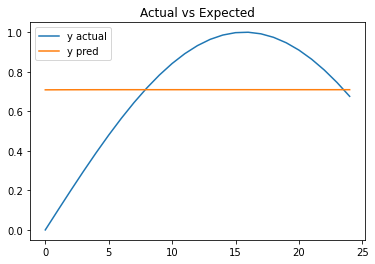

parameters 
 {'Wr': array([[-0.02672884]]), 'Ur': array([[-0.35223855]]), 'br': array([[0.15451251]]), 'Wz': array([[1.42969779]]), 'Uz': array([[-4.22660954]]), 'bz': array([[-8.91489746]]), 'Wh': array([[0.90955671]]), 'Uh': array([[0.51598491]]), 'bh': array([[-2.61412276]]), 'Wy': array([[-2.85549194]]), 'by': array([[0.70687234]])} 

final gradients 
 {'dWr': array([[8.45058324e-12]]), 'dUr': array([[-1.29565517e-08]]), 'dbr': array([[-2.83354086e-08]]), 'dWz': array([[-3.71790418e-06]]), 'dUz': array([[0.01039855]]), 'dbz': array([[0.0102368]]), 'dWh': array([[-6.60681406e-08]]), 'dUh': array([[0.00018875]]), 'dbh': array([[0.00048291]]), 'dWy': array([[0.00038436]]), 'dby': array([[-1.19901452e-05]])} 



In [110]:
parameters = model(X, Y, num_iterations=10000, n_h=1, learning_rate=0.01, print_chart=True, print_grad_updates=False)

Iteration: 0, Loss: 14.712655
Iteration: 1000, Loss: 0.321262
Iteration: 2000, Loss: 0.019703
Iteration: 3000, Loss: 0.003463
Iteration: 4000, Loss: 0.002176
Iteration: 5000, Loss: 0.001749
Iteration: 6000, Loss: 0.001381
Iteration: 7000, Loss: 0.001085
Iteration: 8000, Loss: 0.000853
Iteration: 9000, Loss: 0.000674



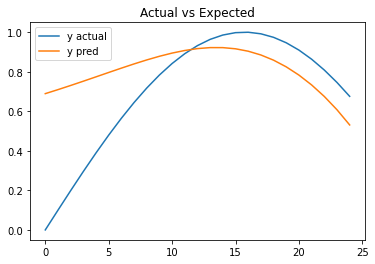

parameters 
 {'Wr': array([[ 0.04334979, -0.02820792],
       [-0.04002292, -0.07251002]]), 'Ur': array([[-0.41800842],
       [-0.3174264 ]]), 'br': array([[0.0990315 ],
       [0.16707073]]), 'Wz': array([[0.9310744 , 0.48026623],
       [1.72728276, 1.20531528]]), 'Uz': array([[1.59735809],
       [0.66717308]]), 'bz': array([[-2.55389023],
       [-3.4364967 ]]), 'Wh': array([[0.57621273, 0.50842295],
       [0.54964465, 0.78084188]]), 'Uh': array([[0.42433561],
       [1.08727249]]), 'bh': array([[-1.93741487],
       [-1.31337597]]), 'Wy': array([[-1.01293512, -1.75925962]]), 'by': array([[-0.13231923]])} 

final gradients 
 {'dWr': array([[-1.67236344e-04, -5.41893990e-05],
       [-4.76148195e-05, -5.62386628e-06]]), 'dUr': array([[0.00010768],
       [0.00010366]]), 'dbr': array([[7.31148237e-05],
       [3.45693088e-05]]), 'dWz': array([[ 9.38400631e-04, -3.62358139e-05],
       [-1.30988765e-04, -9.00608561e-05]]), 'dUz': array([[-2.59651540e-03],
       [-3.42560147e-05]]),

In [113]:
parameters = model(X, Y, num_iterations=10000, n_h=2, learning_rate=0.01, print_chart=True, print_grad_updates=False)

Iteration: 0, Loss: 14.706586
Iteration: 1000, Loss: 0.323967
Iteration: 2000, Loss: 0.017639
Iteration: 3000, Loss: 0.009862
Iteration: 4000, Loss: 0.009506
Iteration: 5000, Loss: 0.004105
Iteration: 6000, Loss: 0.001150
Iteration: 7000, Loss: 0.000433
Iteration: 8000, Loss: 0.000293
Iteration: 9000, Loss: 0.000262



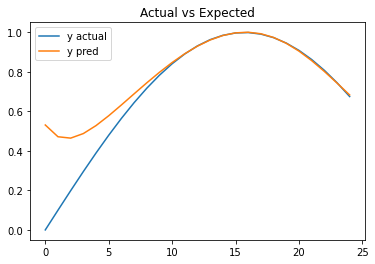

parameters 
 {'Wr': array([[-0.04455425,  0.03830491,  0.03572332],
       [-0.01344893,  0.01144499, -0.02090945],
       [-0.01276039,  0.02074903,  0.04416417]]), 'Ur': array([[-0.33957135],
       [ 0.01197119],
       [-0.31347298]]), 'br': array([[0.14498508],
       [0.0049205 ],
       [0.13966032]]), 'Wz': array([[ 0.84846979, -0.35850643, -0.8805492 ],
       [ 0.03275424, -0.03610414, -0.07958762],
       [ 0.50398408, -0.31853817, -0.58024351]]), 'Uz': array([[ 1.19574476],
       [-0.08662429],
       [ 1.16137305]]), 'bz': array([[-1.83560004],
       [-0.15567906],
       [-1.30660177]]), 'Wh': array([[ 0.63932648, -0.01458564, -0.61458125],
       [-0.09796608,  0.1411004 ,  0.10768247],
       [-0.60559344,  0.03016717,  0.59100231]]), 'Uh': array([[ 0.42534439],
       [-0.55260605],
       [-0.00913652]]), 'bh': array([[-0.8073176 ],
       [ 0.33469374],
       [ 0.89707735]]), 'Wy': array([[-0.91327672, -0.46742992,  0.54161011]]), 'by': array([[-0.09995093]])} 

f

In [114]:
parameters = model(X, Y, num_iterations=10000, n_h=3, learning_rate=0.01, print_chart=True, print_grad_updates=False)

Iteration: 0, Loss: 14.706586
Iteration: 1000, Loss: 0.323967
Iteration: 2000, Loss: 0.017639
Iteration: 3000, Loss: 0.009862
Iteration: 4000, Loss: 0.009506
Iteration: 5000, Loss: 0.004105
Iteration: 6000, Loss: 0.001150
Iteration: 7000, Loss: 0.000433
Iteration: 8000, Loss: 0.000293
Iteration: 9000, Loss: 0.000262
Iteration: 10000, Loss: 0.000248
Iteration: 11000, Loss: 0.000237
Iteration: 12000, Loss: 0.000226
Iteration: 13000, Loss: 0.000216
Iteration: 14000, Loss: 0.000206
Iteration: 15000, Loss: 0.000196
Iteration: 16000, Loss: 0.000188
Iteration: 17000, Loss: 0.000179
Iteration: 18000, Loss: 0.000171
Iteration: 19000, Loss: 0.000164
Iteration: 20000, Loss: 0.000156
Iteration: 21000, Loss: 0.000150
Iteration: 22000, Loss: 0.000143
Iteration: 23000, Loss: 0.000137
Iteration: 24000, Loss: 0.000131
Iteration: 25000, Loss: 0.000126
Iteration: 26000, Loss: 0.000121
Iteration: 27000, Loss: 0.000116
Iteration: 28000, Loss: 0.000111
Iteration: 29000, Loss: 0.000107
Iteration: 30000, Loss

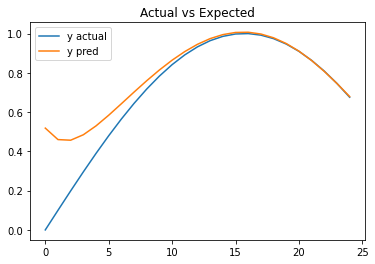

parameters 
 {'Wr': array([[-0.05372756, -0.01800706,  0.0727376 ],
       [-0.01385411,  0.01457855, -0.02099006],
       [-0.04701065,  0.00121952,  0.05702149]]), 'Ur': array([[-0.1892485 ],
       [ 0.00747789],
       [-0.28893487]]), 'br': array([[0.19004267],
       [0.00714843],
       [0.14468512]]), 'Wz': array([[ 0.72023595, -0.30107557, -0.7841309 ],
       [ 0.03850932, -0.09395999, -0.06268957],
       [ 0.4452472 , -0.3014837 , -0.50523083]]), 'Uz': array([[1.16982278],
       [0.0248885 ],
       [1.22204264]]), 'bz': array([[-1.67812993],
       [-0.16894997],
       [-1.1772261 ]]), 'Wh': array([[ 0.73251251,  0.03178783, -0.64812447],
       [-0.06151007,  0.17188139,  0.07288549],
       [-0.60568065,  0.00115976,  0.56530469]]), 'Uh': array([[ 0.38958322],
       [-0.59163606],
       [-0.04123792]]), 'bh': array([[-0.75218816],
       [ 0.31829402],
       [ 0.74488113]]), 'Wy': array([[-0.92432983, -0.48158775,  0.42187478]]), 'by': array([[-0.08624373]])} 

fina

In [115]:
parameters = model(X, Y, num_iterations=50000, n_h=3, learning_rate=0.01, print_chart=True, print_grad_updates=False)

### 2. Multiple Examples

In [116]:
# Create training data with multiple examples
T_x = 25
m = 100

X = np.zeros((T_x, m))

for col in range(X.shape[1]):
  r = np.random.randint(1, 20)
  X[:, col] = [x/10.0 for x in range(r, r + T_x)]

Y = np.sin(X)

X.shape

(25, 100)

Iteration: 0, Loss: 1285.392496
Iteration: 1000, Loss: 275.539821
Iteration: 2000, Loss: 275.539515
Iteration: 3000, Loss: 275.539442
Iteration: 4000, Loss: 275.539410
Iteration: 5000, Loss: 275.539391
Iteration: 6000, Loss: 275.539379
Iteration: 7000, Loss: 275.539371
Iteration: 8000, Loss: 275.539365
Iteration: 9000, Loss: 275.539360



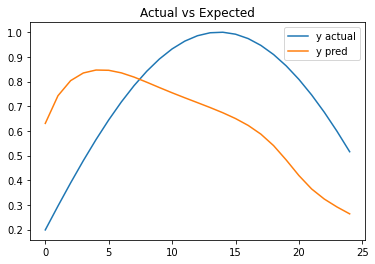

parameters 
 {'Wr': array([[ 4.61327001, -0.47919887, -4.63188553],
       [ 4.11990603,  1.38756854, -3.74476909],
       [-2.24138529, -0.31854813,  2.17467387]]), 'Ur': array([[-5.35290649],
       [ 4.6451491 ],
       [ 6.63986165]]), 'br': array([[ 4.9442093 ],
       [ 1.60466372],
       [-2.00813333]]), 'Wz': array([[ -0.45786196,   4.74917575,   0.45841208],
       [-11.7200494 ,  -4.20504801,  10.61787201],
       [ -0.46163049,   4.71809337,   0.44626166]]), 'Uz': array([[  6.80374405],
       [-15.01490415],
       [  0.55630239]]), 'bz': array([[ -0.0883886 ],
       [-14.51485397],
       [  0.07438165]]), 'Wh': array([[ 5.51876942e-01, -5.16866661e+00, -2.72529409e-03],
       [ 2.39475355e+00,  2.17591944e+00, -2.33079713e+00],
       [-2.88428969e-01,  5.18309096e+00, -1.84383673e-01]]), 'Uh': array([[0.41874796],
       [2.55583704],
       [0.31425738]]), 'bh': array([[ 0.59302587],
       [ 2.07954033],
       [-0.88736859]]), 'Wy': array([[ 0.05976373,  0.42605023

In [120]:
parameters = model(X, Y, num_iterations=10000, n_h=3, learning_rate=0.005, print_chart=True, print_grad_updates=False, grad_max=10)